# Data Science Capstone Project - The Battle of the Neighborhoods

## Introduction

Miami is a metropolis in the southeastern part of the state of Florida. It is the second largest city in the state and seventh largest in the country. It is in Miami-Dade county, FL.
<br/><br/>
Miami is one of the most popular places to retire nowadays. People choose to spend their retirement life there because of high health care quality, convenient and relaxing life styles, beautiful climate, recreational opportunities all year round, and many more.
<br/><br/>
In this project, I will use data science skills to help customers who would consider relocating to Miami after retirement to get familiar with the city, as well as to find some areas they might be interested in. As most retired people take major consideration on easy access to hospital facilities, grocery shopping markets, indoor entertainment places and outdoor opportunities, I will focus on the analysis and comparison of different zip code areas on these four specific category groups. A detailed report and effective presentation will be provided to the customers
so they can make their final decision based on their individual requirements or interests.

## Data
To solve the problem, the following data is needed:
1. List of zips in Miami and related information, such as latitude and longitude coordinates and population of those zips. These information are required to plot the map, get the venue data, and do all the analysis.
<br/><br/>
2. Use geopy library to get the geographical coordinates of Miami, FL.
<br/><br/>
3. Use Foursquare API to get the most common venues for each zip in Miami. Those venue data in some category groups of interest are particularly useful for this project. The venue data are also used to perform clustering on different zips.

## Methodology
I used the following libraries or APIs in this project:
1. pandas for data manipulation and analysis.
<br/><br/>
2. geopy library to get the geographical coordinates of a location.
<br/><br/>
3. Python Folium library to visualize geospatial data.
<br/><br/>
4. Foursquare API to explore venues for different locations.
<br/><br/>
5. Matplotlib library and associated modules for plotting.
<br/><br/>
7. Scikit-learn kmeans as the method of unsupervised learning to cluster the zips.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  [Download and Explore Dataset](#section1)

2.  [Use the Foursquare API to explore each zip](#section2)

3.  [Analyze the zips in Miami](#section3)

4.  [Cluster the zips and examine the clusters](#section4)

5.  [Result](#section5)  
    
6.  [Discussion](#section6)
    
7.  [Conclusion](#section7)
    </font>
    </div>

### Import libraries.

In [1]:
import pandas as pd

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library

import requests # library to handle requests
import json # library to handle JSON files

import numpy as np

# import k-means from clustering stage
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib as mpl

import matplotlib.pyplot as plt

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

## 1. Download and Explore Dataset <a id='section1'></a>

### Obtain the data and then transform the data into a pandas dataframe.

In [2]:
df = pd.read_csv('zip_code_database.csv')
df.head()

,zip,type,decommissioned,primary_city,acceptable_cities,unacceptable_cities,state,county,timezone,area_codes,world_region,country,latitude,longitude,irs_estimated_population_2015
0,501,UNIQUE,0,Holtsville,NaN,I R S Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,562
1,544,UNIQUE,0,Holtsville,NaN,Irs Service Center,NY,Suffolk County,America/New_York,631,NaN,US,40.81,-73.04,0
2,601,STANDARD,0,Adjuntas,NaN,"Colinas Del Gigante, Jard De Adjuntas, Urb San...",PR,Adjuntas Municipio,America/Puerto_Rico,"787,939",NaN,US,18.16,-66.72,0
3,602,STANDARD,0,Aguada,NaN,"Alts De Aguada, Bo Guaniquilla, Comunidad Las ...",PR,Aguada Municipio,America/Puerto_Rico,"787,939",NaN,US,18.38,-67.18,0
4,603,STANDARD,0,Aguadilla,Ramey,"Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...",PR,Aguadilla Municipio,America/Puerto_Rico,787,NaN,US,18.43,-67.15,0


In [3]:
df.shape

(42632, 15)

### Extract the related data for Miami, FL.

In [4]:
# Found all standard (residential) zip codes in Miami, Florida.
miami_df = df[(df['type'] == 'STANDARD') & (df['state'] == 'FL') & (df['primary_city'] == 'Miami')].reset_index(drop=True)
miami_df = miami_df[miami_df['irs_estimated_population_2015'] > 0]
miami_df.shape

(56, 15)

In [5]:
print('There are {} standard zip codes in Miami, FL.'.format(len(miami_df['zip'].unique())))

There are 56 standard zip codes in Miami, FL.


In [6]:
miami_data = miami_df[['zip', 'primary_city', 'county', 'latitude', 'longitude', 'irs_estimated_population_2015']]
miami_data.dtypes

zip                                int64
primary_city                      object
county                            object
latitude                         float64
longitude                        float64
irs_estimated_population_2015      int64
dtype: object

In [7]:
miami_data.head()

,zip,primary_city,county,latitude,longitude,irs_estimated_population_2015
0,33122,Miami,Miami-Dade County,25.79,-80.30,1146
1,33125,Miami,Miami-Dade County,25.78,-80.24,43170
2,33126,Miami,Miami-Dade County,25.78,-80.30,42520
3,33127,Miami,Miami-Dade County,25.81,-80.21,24030
4,33128,Miami,Miami-Dade County,25.78,-80.20,5110


### Use geopy library to get the geographical coordinates of Miami, FL.

In [8]:
address = 'Miami, FL'

geolocator = Nominatim(user_agent="miami_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Miami, FL are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Miami, FL are 25.7741728, -80.19362.


### Create the map of Miami.

In [9]:
map_miami = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, label in zip(miami_data['latitude'], miami_data['longitude'], miami_data['zip']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_miami)  
    
map_miami


## 2. Use the Foursquare API to explore each zip <a id='section2'></a>

#### Define Foursquare Credentials, Categories, Version and Limit.

In [10]:
CLIENT_ID = '0ZN550UKPZWBMYJIE3Q4SSHKRLAT5IBQLBBDNUD0V1PBOKGT'
CLIENT_SECRET = 'KXZ12AWNRH55X1NBV20EPNXOUGDDAQBCVN0PJCKEQA4NN5BO'

CATEGORY_ID = '5032792091d4c4b30a586d5c,\
4bf58dd8d48988d17f941735,\
4bf58dd8d48988d181941735,\
4bf58dd8d48988d176941735,\
4bf58dd8d48988d15a941735,\
4bf58dd8d48988d161941735,\
4bf58dd8d48988d163941735,\
4bf58dd8d48988d159941735,\
52e81612bcbc57f1066b7a34,\
4bf58dd8d48988d12f941735,\
4bf58dd8d48988d196941735,\
4bf58dd8d48988d1fa941735,\
4bf58dd8d48988d118951735,\
56aa371be4b08b9a8d573526,\
4bf58dd8d48988d194941735,\
4bf58dd8d48988d1e2941735,\
4bf58dd8d48988d1fa941735,\
52f2ab2ebcbc57f1066b8b46'

VERSION = '20200104' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

Define a function to get the venues.

In [11]:
# For each zip code, get the top 100 (or less if there are not as much as 100) venues that are in the city within a radius of about 10 miles.
def getNearbyVenues(zips, names, latitudes, longitudes, populations, radius=16000):
    
    venues_list=[]
    for zip_code, name, lat, lng, population in zip(zips, names, latitudes, longitudes, populations):
        print(zip_code, name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            CATEGORY_ID,
            LIMIT)
        
        #print(url)    
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            zip_code, 
            lat, 
            lng, 
            population,
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])    
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Zip', 
                  'Primary city Latitude', 
                  'Primary city Longitude', 
                  'Population',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Call the above function on each zip of Miami, and create a new venues dataframe.

In [12]:
venues = getNearbyVenues(zips=miami_data['zip'], names=miami_data['primary_city'], latitudes=miami_data['latitude'], longitudes=miami_data['longitude'], populations=miami_data['irs_estimated_population_2015'])

33122 Miami
33125 Miami
33126 Miami
33127 Miami
33128 Miami
33129 Miami
33130 Miami
33131 Miami
33132 Miami
33133 Miami
33134 Miami
33135 Miami
33136 Miami
33137 Miami
33138 Miami
33142 Miami
33143 Miami
33144 Miami
33145 Miami
33146 Miami
33147 Miami
33150 Miami
33155 Miami
33156 Miami
33157 Miami
33158 Miami
33161 Miami
33162 Miami
33165 Miami
33166 Miami
33167 Miami
33168 Miami
33169 Miami
33170 Miami
33172 Miami
33173 Miami
33174 Miami
33175 Miami
33176 Miami
33177 Miami
33178 Miami
33179 Miami
33180 Miami
33181 Miami
33182 Miami
33183 Miami
33184 Miami
33185 Miami
33186 Miami
33187 Miami
33189 Miami
33190 Miami
33192 Miami
33193 Miami
33194 Miami
33196 Miami


In [13]:
venues

,Zip,Primary city Latitude,Primary city Longitude,Population,Venue,Venue Latitude,Venue Longitude,Venue Category
0,33122,25.79,-80.30,1146,Publix,25.779707,-80.289079,Grocery Store
1,33122,25.79,-80.30,1146,Publix,25.771784,-80.331520,Grocery Store
2,33122,25.79,-80.30,1146,Publix,25.756681,-80.287935,Grocery Store
3,33122,25.79,-80.30,1146,Walmart Neighborhood Market,25.764574,-80.308947,Grocery Store
4,33122,25.79,-80.30,1146,The Fresh Market,25.809367,-80.331574,Grocery Store
...,...,...,...,...,...,...,...,...
5575,33196,25.65,-80.49,45390,Baptist Health Medical Plaza at Country Walk :...,25.627663,-80.415113,Urgent Care Center
5576,33196,25.65,-80.49,45390,Planet Fitness,25.589059,-80.357758,Gym / Fitness Center
5577,33196,25.65,-80.49,45390,ALDI,25.585129,-80.364470,Grocery Store
5578,33196,25.65,-80.49,45390,Sedano's,25.746287,-80.390865,Grocery Store


#### Check how many venues were returned for each zip.

In [14]:
venue_df = venues.groupby('Zip').count()
venue_df[['Venue']]

,Venue
Zip,
33122,100
33125,100
33126,100
33127,100
33128,100
33129,100
33130,100
33131,100
33132,100


#### Find out the number of unique categories and list all of them.

In [15]:
print('There are {} unique categories.'.format(len(venues['Venue Category'].unique())))

There are 53 unique categories.


In [16]:
venues['Venue Category'].unique()

array(['Grocery Store', 'Park', 'Supermarket', 'Big Box Store',
       'Gym / Fitness Center', 'Library', 'Golf Course', 'Beach',
       'Movie Theater', 'Gym', 'Museum', 'Trail', 'Multiplex', 'Garden',
       'Theater', 'Concert Hall',
       'Residential Building (Apartment / Condo)', 'Art Museum',
       'Harbor / Marina', 'Hospital', 'Performing Arts Venue', 'Hotel',
       'Island', 'Boat or Ferry', 'Historic Site', 'Farmers Market',
       'Parking', 'Medical Center', 'State / Provincial Park',
       'Botanical Garden', 'Food & Drink Shop', 'Community Center',
       'Basketball Court', 'Nudist Beach', 'Other Great Outdoors',
       'Building', 'Resort', 'College Gym', 'Garden Center', 'Dog Run',
       'Urgent Care Center', 'Playground', 'Emergency Room',
       'Event Space', 'Health Food Store', 'Field', 'Nature Preserve',
       'Lake', 'Track', 'Cycle Studio', 'Preschool', 'Shopping Plaza',
       'Hospital Ward'], dtype=object)


## 3. Analyze the zips in Miami <a id='section3'></a>

### Step 1: Convert venues dataframe into a dataframe grouped by zips and show all categories of interest.

Use pandas get_dummies function to convert category values into numerical values.

In [17]:
# one hot encoding
onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add Zip column back to dataframe
onehot['Zip'] = venues['Zip'] 

# move Zip column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

onehot.head()

,Zip,Art Museum,Basketball Court,Beach,Big Box Store,Boat or Ferry,Botanical Garden,Building,College Gym,Community Center,...,Preschool,Residential Building (Apartment / Condo),Resort,Shopping Plaza,State / Provincial Park,Supermarket,Theater,Track,Trail,Urgent Care Center
0,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
onehot_selected = onehot.copy()

#### Combine some similar types of venue categories.
First, let's define a function to combine some related venues.

In [19]:
def combine_venues(df_name, combined_col, list_name):
    df_name.loc[:,combined_col] = df_name.reindex(columns=list_name).sum(axis = 1).astype(int)

Combine all types of museums

In [20]:
museum_list = [col for col in onehot.columns if 'Museum' in col]
print(museum_list)

['Art Museum', 'Museum']


In [21]:
combine_venues(onehot_selected, 'Museums', museum_list)
onehot_selected

,Zip,Art Museum,Basketball Court,Beach,Big Box Store,Boat or Ferry,Botanical Garden,Building,College Gym,Community Center,...,Residential Building (Apartment / Condo),Resort,Shopping Plaza,State / Provincial Park,Supermarket,Theater,Track,Trail,Urgent Care Center,Museums
0,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5575,33196,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5576,33196,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5577,33196,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5578,33196,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Combine all types of gyms.

In [22]:
gym_list = [col for col in onehot.columns if 'Gym' in col]
print(gym_list)

['College Gym', 'Gym', 'Gym / Fitness Center']


In [23]:
combine_venues(onehot_selected, 'Gyms', gym_list)
onehot_selected.head()

,Zip,Art Museum,Basketball Court,Beach,Big Box Store,Boat or Ferry,Botanical Garden,Building,College Gym,Community Center,...,Resort,Shopping Plaza,State / Provincial Park,Supermarket,Theater,Track,Trail,Urgent Care Center,Museums,Gyms
0,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Combine all types of movie theaters.

In [24]:
movie_theater_list = ['Movie Theater','Indie Movie Theater', 'Multiplex']
combine_venues(onehot_selected, 'Movie Theaters', movie_theater_list)
onehot_selected.head()

,Zip,Art Museum,Basketball Court,Beach,Big Box Store,Boat or Ferry,Botanical Garden,Building,College Gym,Community Center,...,Shopping Plaza,State / Provincial Park,Supermarket,Theater,Track,Trail,Urgent Care Center,Museums,Gyms,Movie Theaters
0,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33122,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Now, we only list venues of intest for all the zips.
This dataframe is also our baseline for clustering in section 4.

In [25]:
onehot_selected = onehot_selected[['Zip',
                                'Hospital', 'Medical Center', 'Urgent Care Center', 'Emergency Room', 'Hospital Ward',
                                'Grocery Store', 'Farmers Market', 'Supermarket',
                                'Library', 'Gyms', 'Museums', 'Movie Theaters', 'Community Center', 'Concert Hall',
                                'Park', 'Trail', 'Lake', 'Garden', 'Beach', 'Nature Preserve']]
onehot_selected

,Zip,Hospital,Medical Center,Urgent Care Center,Emergency Room,Hospital Ward,Grocery Store,Farmers Market,Supermarket,Library,...,Museums,Movie Theaters,Community Center,Concert Hall,Park,Trail,Lake,Garden,Beach,Nature Preserve
0,33122,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,33122,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,33122,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,33122,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,33122,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5575,33196,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5576,33196,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5577,33196,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5578,33196,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Group by Zip to get a dataframe showing all venues of each zip.

In [26]:
selected_venues = onehot_selected.groupby('Zip').sum().reset_index()
selected_venues

,Zip,Hospital,Medical Center,Urgent Care Center,Emergency Room,Hospital Ward,Grocery Store,Farmers Market,Supermarket,Library,...,Museums,Movie Theaters,Community Center,Concert Hall,Park,Trail,Lake,Garden,Beach,Nature Preserve
0,33122,0,0,0,0,0,44,0,2,2,...,2,3,0,1,21,2,0,1,1,0
1,33125,2,0,0,0,0,30,0,2,1,...,2,4,0,3,26,3,0,1,10,0
2,33126,2,0,0,0,0,40,0,2,2,...,2,4,0,1,22,2,0,1,1,0
3,33127,0,0,0,0,0,27,0,2,1,...,2,3,0,3,21,3,0,1,20,0
4,33128,1,0,0,0,0,20,0,1,1,...,2,4,0,3,24,4,0,1,22,0
5,33129,0,0,0,0,0,20,0,1,1,...,2,4,0,3,25,3,0,1,20,0
6,33130,1,0,0,0,0,21,0,1,1,...,2,4,0,3,24,4,0,1,20,0
7,33131,0,0,0,0,0,19,0,1,0,...,2,3,0,3,24,4,0,1,25,0
8,33132,1,0,0,0,0,18,0,1,0,...,2,3,0,3,23,4,0,1,26,0
9,33133,1,0,0,0,0,31,1,1,1,...,2,4,0,3,26,2,0,1,8,0


In [27]:
# Add 'Population' column to the selected_venues dataframe.
selected_venues['Population'] = miami_data['irs_estimated_population_2015'].values
selected_venues

,Zip,Hospital,Medical Center,Urgent Care Center,Emergency Room,Hospital Ward,Grocery Store,Farmers Market,Supermarket,Library,...,Movie Theaters,Community Center,Concert Hall,Park,Trail,Lake,Garden,Beach,Nature Preserve,Population
0,33122,0,0,0,0,0,44,0,2,2,...,3,0,1,21,2,0,1,1,0,1146
1,33125,2,0,0,0,0,30,0,2,1,...,4,0,3,26,3,0,1,10,0,43170
2,33126,2,0,0,0,0,40,0,2,2,...,4,0,1,22,2,0,1,1,0,42520
3,33127,0,0,0,0,0,27,0,2,1,...,3,0,3,21,3,0,1,20,0,24030
4,33128,1,0,0,0,0,20,0,1,1,...,4,0,3,24,4,0,1,22,0,5110
5,33129,0,0,0,0,0,20,0,1,1,...,4,0,3,25,3,0,1,20,0,11920
6,33130,1,0,0,0,0,21,0,1,1,...,4,0,3,24,4,0,1,20,0,21170
7,33131,0,0,0,0,0,19,0,1,0,...,3,0,3,24,4,0,1,25,0,15540
8,33132,1,0,0,0,0,18,0,1,0,...,3,0,3,23,4,0,1,26,0,7770
9,33133,1,0,0,0,0,31,1,1,1,...,4,0,3,26,2,0,1,8,0,28030


#### After all the processing from the venues dataframe, finally we got the selected venues grouped by zip codes. Let's go to the next step.

### Step 2: Analyze the zip codes and compare them.

#### Define a grouping function, a sorting function, and two plotting functions.

Define a grouping function to extract venues categories in the comparing group.

In [28]:
def create_comparing_group(original_df, comparing_group_list_name):
    columns_list = ['Zip', 'Population']
    for each in comparing_group_list_name:
        columns_list.append(each)
    comparing_group_df = original_df.reindex(columns = columns_list)
    comparing_group_df.loc[:,'Total'] = comparing_group_df.loc[:, comparing_group_list_name].sum(axis = 1).astype(int)
    comparing_group_df.loc[:,'Per 1000 people'] = round(comparing_group_df.loc[:,'Total'] / comparing_group_df.loc[:,'Population'] *1000,2)
    return comparing_group_df    

Define a sorting function to sort a dataframe by some criteria.

In [29]:
def sort_venues_by(original_df, comparing_by, comparing_by_2, top_number, is_ascending, category_group_name, appendix_str):
    
    # sorting by comparing_by
    venues_top_temp = original_df.sort_values(by=comparing_by, ascending=is_ascending).head(top_number).reset_index(drop=True)
    
    # for plotting purpose
    comparing_by_max = venues_top_temp[comparing_by].max() 
    
    # there might be ties at the ranking top_number, in that case, we need to get all the zips even the number is more than top_number    
    top_min = venues_top_temp[comparing_by].min() 
    venues_top_without_order = original_df[original_df[comparing_by] >= top_min].reset_index(drop=True)
    
    # as we already got all the top zips, we need to put the them back in order by comparing_by, then by comparing_by_2
    venues_top = venues_top_without_order.iloc[np.lexsort((venues_top_without_order[comparing_by_2], -venues_top_without_order[comparing_by]))].reset_index(drop=True)
    
    # calculate the number of top zips in this category
    top_number_with_ties = len(venues_top.index)
    print('There are {} zips with the most numbers of venues in the {}{} category.'.format(
                top_number_with_ties, category_group_name, appendix_str))
    
    # for plotting purpose
    venues_top_reverse = venues_top[['Zip', comparing_by]].iloc[::-1]
    
    return venues_top, venues_top_reverse, comparing_by_max, top_number_with_ties

Define a plotting function to plot a bar chart to show the total counts of the category group for the top zips.

In [30]:
def plot_category_group_total_bar(df, x_axis, y_axis, category_group_str, appendix_str, max_number, top_number_with_ties):
    
    x_label = 'Number of ' + category_group_str + ' ' + appendix_str
    y_label = 'Zip'
    title = 'Top ' + str(top_number_with_ties) + ' Zips In Miami That Have The Most ' + category_group_str + ' ' + appendix_str
    
    df.plot(x=x_axis, y=y_axis, kind='barh', figsize=(8, 6), color='steelblue', fontsize=12, legend=None)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(title, fontsize=16)

    plt.xlim(0, max_number*1.2)

    text_height = 0

    for each in df[[x_axis,y_axis]].values:
        text_height = text_height + 1
        index=int(each[0])
        value=each[1]
        label = format(int(value), ',')
        plt.text(value+0.3, text_height-1.1, value, fontsize=12)
        
    plt.show()

Define a plotting function to plot a bar chart to show the count of each category in the category group for the top zips.

In [31]:
def plot_category_group_bar(df, comparing_group_list_name, category_group_str, appendix_str, top_number_with_ties):
    color_list = ['#5cb85c', '#f0ad4e', '#5bc0de', '#d9534f', '#337ab7', '#f9e79f']
    
    num_in_list = len(comparing_group_list_name)
    plot_color_list = []
    for i in range(num_in_list):
        plot_color_list.append(color_list[i])
    
    ax = df[comparing_group_list_name].plot(kind='bar', 
             figsize=(20, 8), 
             width=0.8,
             color=plot_color_list,
             fontsize=13
            )

    ax.set_title('{} In The Top {} Zips That Have The Most {}'.format(
            category_group_str, str(top_with_ties), category_group_str+' '+appendix_str), fontsize=16)
    ax.set_xlabel('Zip', fontsize=12)
    ax.legend(fontsize=13)

    # Display the numbers above the bars
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height:}', (x + width/2, y + height*1.02), ha='center', fontsize=12)
 
    # Remove the left, top, and right borders
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

#### 1) Hospital Facilities (hospitals, medical centers, urgent care centers, emergency rooms, and hospital wards)

Get the hospital facilities venue dataframe for all zips.

In [32]:
# Combine 'Hospital', 'Medical Center', 'Urgent Care Center', 'Emergency Room', and 'Hospital Ward' to be 'Hospital Facilities'
hospital_list = ['Hospital', 'Medical Center', 'Urgent Care Center', 'Emergency Room', 'Hospital Ward']

In [33]:
hospital_venues = create_comparing_group(selected_venues, hospital_list)
hospital_venues.head()

,Zip,Population,Hospital,Medical Center,Urgent Care Center,Emergency Room,Hospital Ward,Total,Per 1000 people
0,33122,1146,0,0,0,0,0,0,0.00
1,33125,43170,2,0,0,0,0,2,0.05
2,33126,42520,2,0,0,0,0,2,0.05
3,33127,24030,0,0,0,0,0,0,0.00
4,33128,5110,1,0,0,0,0,1,0.20


##### (1) One question that customers will be interested in is which zips have the most hospitals, medical centers, urgent care centers,  ERs, and hospital wards

In [34]:
# sort by total number of Hosital Facilties in each zip
venues_total_top, venues_total_top_reverse, total_max, top_with_ties = sort_venues_by(
                    hospital_venues, 'Total', 'Zip', 10, False, 'Hosital Facilities', '')
venues_total_top

There are 20 zips with the most numbers of venues in the Hosital Facilities category.


,Zip,Population,Hospital,Medical Center,Urgent Care Center,Emergency Room,Hospital Ward,Total,Per 1000 people
0,33194,5430,10,1,3,2,1,17,3.13
1,33189,22740,7,1,0,0,0,8,0.35
2,33190,13080,7,1,0,0,0,8,0.61
3,33157,60480,6,1,0,0,0,7,0.12
4,33196,45390,3,2,2,0,0,7,0.15
5,33158,6430,5,1,0,0,0,6,0.93
6,33175,50630,4,1,0,1,0,6,0.12
7,33177,51550,4,1,1,0,0,6,0.12
8,33187,17200,5,0,1,0,0,6,0.35
9,33155,41220,4,1,0,0,0,5,0.12


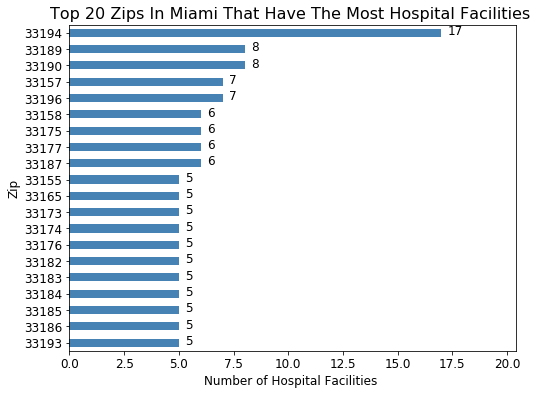

In [35]:
plot_category_group_total_bar(venues_total_top_reverse, 
                              'Zip',
                              'Total',
                              'Hospital Facilities', 
                              '',
                              total_max,
                              top_with_ties)

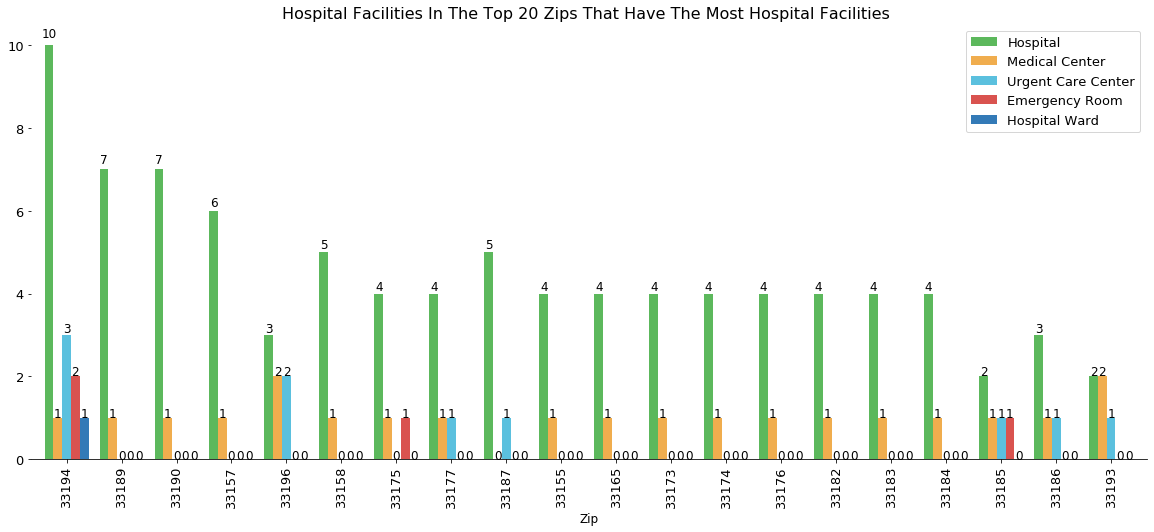

In [36]:
plot_category_group_bar(venues_total_top.set_index('Zip'), hospital_list, 'Hospital Facilities', '', top_with_ties)

##### (2) Another useful information is which zips have the most hospitals, medical centers, urgent care centers, ERs, and hospital wards per 1000 people

In [37]:
# sort by the number of Hosital Facilties per 1000 people in each zip
venues_average_top, venues_average_top_reverse, average_max, top_with_ties = sort_venues_by(
                        hospital_venues, 'Per 1000 people', 'Zip', 10, False, 'Hosital Facilities', ' per 1000 people')
venues_average_top

There are 10 zips with the most numbers of venues in the Hosital Facilities per 1000 people category.


,Zip,Population,Hospital,Medical Center,Urgent Care Center,Emergency Room,Hospital Ward,Total,Per 1000 people
0,33194,5430,10,1,3,2,1,17,3.13
1,33192,550,1,0,0,0,0,1,1.82
2,33158,6430,5,1,0,0,0,6,0.93
3,33190,13080,7,1,0,0,0,8,0.61
4,33146,10010,3,1,0,0,0,4,0.40
5,33182,13380,4,1,0,0,0,5,0.37
6,33187,17200,5,0,1,0,0,6,0.35
7,33189,22740,7,1,0,0,0,8,0.35
8,33170,12430,3,0,1,0,0,4,0.32
9,33184,19510,4,1,0,0,0,5,0.26


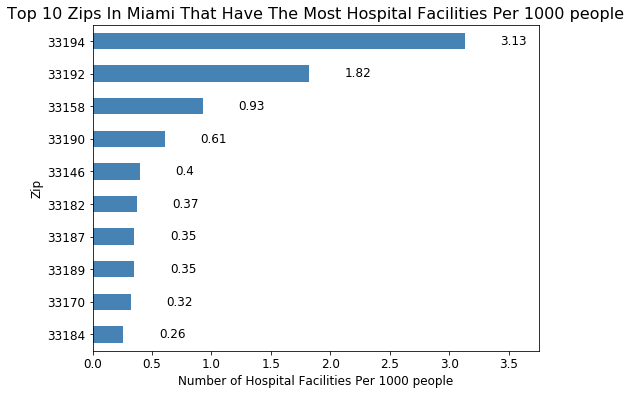

In [38]:
plot_category_group_total_bar(venues_average_top_reverse, 
                              'Zip',
                              'Per 1000 people',
                              'Hospital Facilities', 
                              'Per 1000 people',
                              average_max,
                              top_with_ties)

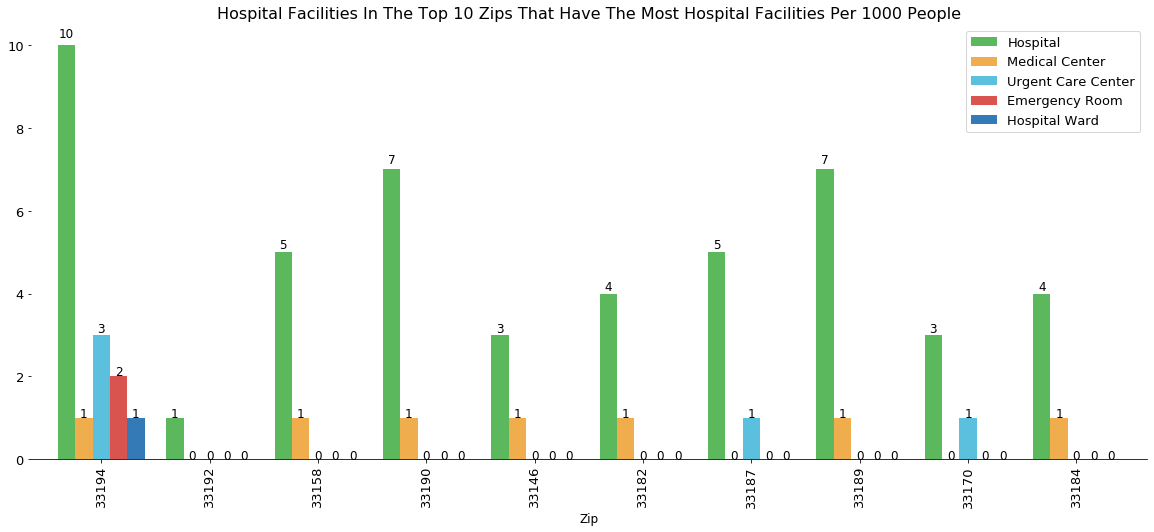

In [39]:
plot_category_group_bar(venues_average_top.set_index('Zip'), hospital_list, 'Hospital Facilities', 'Per 1000 People', top_with_ties)

#### 2) Grocery Facilities (grocery stores, farmers markets, and supermarkets)

Get the grocery facilities venue dataframe for all zips.

In [40]:
# Combine 'Grocery Store', 'Farmers Market', 'Supermarket' to be 'Grocery Facilities'
grocery_list = ['Grocery Store', 'Farmers Market', 'Supermarket']

In [41]:
grocery_venues = create_comparing_group(selected_venues, grocery_list)
grocery_venues.head()

,Zip,Population,Grocery Store,Farmers Market,Supermarket,Total,Per 1000 people
0,33122,1146,44,0,2,46,40.14
1,33125,43170,30,0,2,32,0.74
2,33126,42520,40,0,2,42,0.99
3,33127,24030,27,0,2,29,1.21
4,33128,5110,20,0,1,21,4.11


##### (1) Which zips have the most grocery stores, farmers markets and supermarkets? 

In [42]:
# sort by total number of Grocery Facilties in each zip
venues_total_top, venues_total_top_reverse, total_max, top_with_ties = sort_venues_by(
                    grocery_venues, 'Total', 'Zip', 10, False, 'Grocery Facilities', '')
venues_total_top

There are 14 zips with the most numbers of venues in the Grocery Facilities category.


,Zip,Population,Grocery Store,Farmers Market,Supermarket,Total,Per 1000 people
0,33172,37900,54,1,2,57,1.50
1,33186,63130,49,5,2,56,0.89
2,33176,46890,52,2,1,55,1.17
3,33183,34040,52,3,0,55,1.62
4,33173,29710,51,1,2,54,1.82
5,33174,26640,51,1,2,54,2.03
6,33165,50710,50,1,2,53,1.05
7,33182,13380,51,1,1,53,3.96
8,33175,50630,49,2,1,52,1.03
9,33178,41830,50,0,2,52,1.24


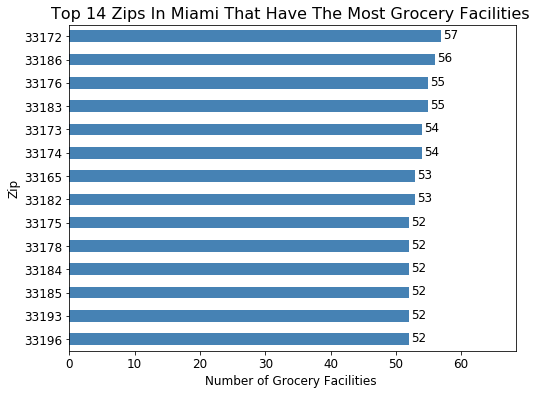

In [43]:
plot_category_group_total_bar(venues_total_top_reverse, 
                              'Zip',
                              'Total',
                              'Grocery Facilities', 
                              '',
                              total_max,
                              top_with_ties)

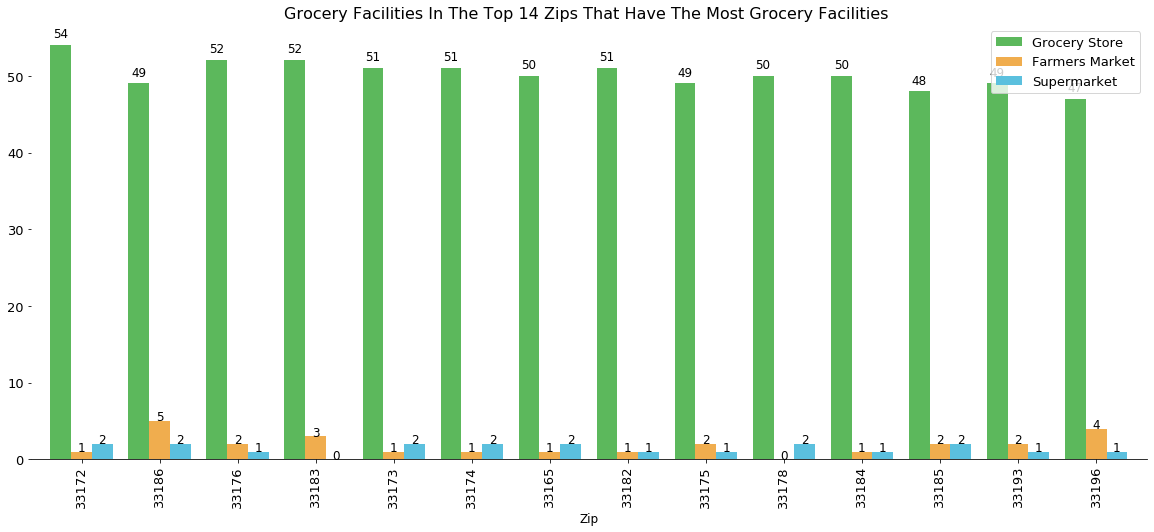

In [44]:
plot_category_group_bar(venues_total_top.set_index('Zip'), grocery_list, 'Grocery Facilities', '', top_with_ties)

##### (2) Which zips have the most grocery stores, farmers markets, or supermarkets facilities per 1000 people?

In [45]:
# sort by the number of Grocery Facilties per 1000 people in each zip
venues_average_top, venues_average_top_reverse, average_max, top_with_ties = sort_venues_by(
                        grocery_venues, 'Per 1000 people', 'Zip', 10, False, 'Grocery Facilities', ' per 1000 people')
venues_average_top

There are 10 zips with the most numbers of venues in the Grocery Facilities per 1000 people category.


,Zip,Population,Grocery Store,Farmers Market,Supermarket,Total,Per 1000 people
0,33122,1146,44,0,2,46,40.14
1,33192,550,21,0,1,22,40.00
2,33158,6430,47,1,2,50,7.78
3,33128,5110,20,0,1,21,4.11
4,33170,12430,44,6,0,50,4.02
5,33182,13380,51,1,1,53,3.96
6,33146,10010,37,1,1,39,3.90
7,33194,5430,20,1,0,21,3.87
8,33190,13080,39,5,1,45,3.44
9,33187,17200,41,5,2,48,2.79


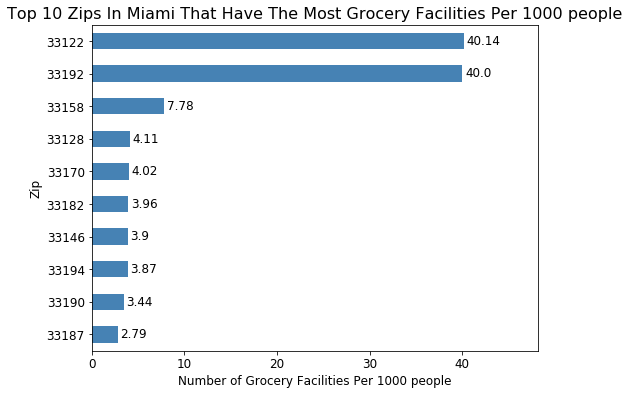

In [46]:
plot_category_group_total_bar(venues_average_top_reverse, 
                              'Zip',
                              'Per 1000 people',
                              'Grocery Facilities', 
                              'Per 1000 people',
                              average_max,
                              top_with_ties)

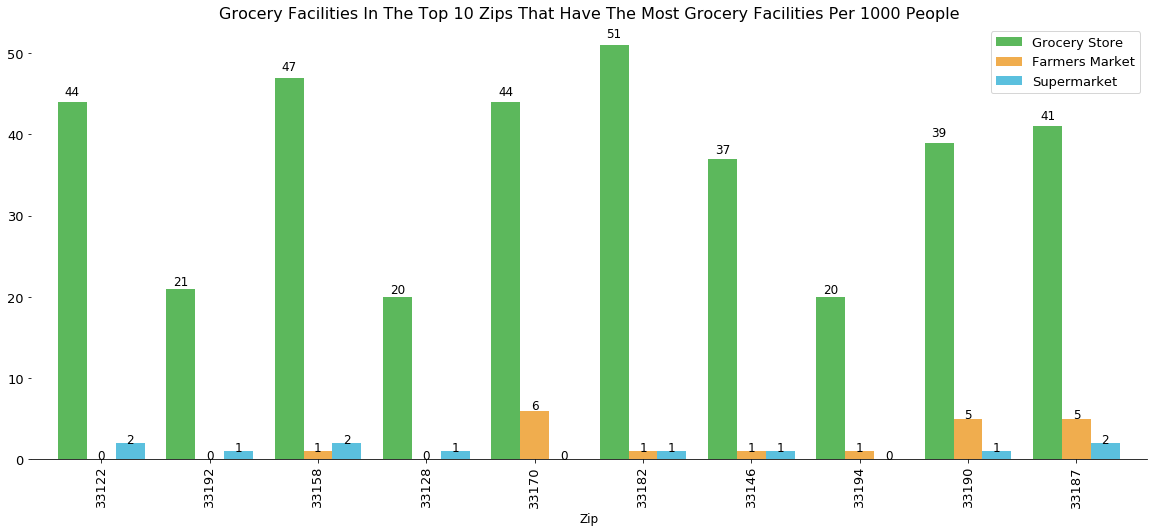

In [47]:
plot_category_group_bar(venues_average_top.set_index('Zip'), grocery_list, 'Grocery Facilities', 'Per 1000 People', top_with_ties)

#### 3) Indoor Facilities (libraries, gyms, museums, movie theaters, community centers, concert halls)

Get the indoor facilities venue dataframe for all zips.

In [48]:
# Combine 'Library', 'Gyms', 'Museums', 'Movie Theaters', 'Community Center', 'Concert Hall' to be 'Indoor Facilities'
indoor_list = ['Library', 'Gyms', 'Museums', 'Movie Theaters', 'Community Center', 'Concert Hall']

In [49]:
indoor_venues = create_comparing_group(selected_venues, indoor_list)
indoor_venues.head()

,Zip,Population,Library,Gyms,Museums,Movie Theaters,Community Center,Concert Hall,Total,Per 1000 people
0,33122,1146,2,12,2,3,0,1,20,17.45
1,33125,43170,1,10,2,4,0,3,20,0.46
2,33126,42520,2,12,2,4,0,1,21,0.49
3,33127,24030,1,9,2,3,0,3,18,0.75
4,33128,5110,1,10,2,4,0,3,20,3.91


##### (1) Which zips have the most libraries, gyms, museums, movie theaters, community centers, and concert halls?

In [50]:
# sort by total number of Indoor Facilties in each zip
venues_total_top, venues_total_top_reverse, total_max, top_with_ties = sort_venues_by(
                    indoor_venues, 'Total', 'Zip', 10, False, 'Indoor Facilities', '')
venues_total_top

There are 16 zips with the most numbers of venues in the Indoor Facilities category.


,Zip,Population,Library,Gyms,Museums,Movie Theaters,Community Center,Concert Hall,Total,Per 1000 people
0,33166,22220,2,15,1,4,0,1,23,1.04
1,33129,11920,1,12,2,4,0,3,22,1.85
2,33133,28030,1,12,2,4,0,3,22,0.78
3,33126,42520,2,12,2,4,0,1,21,0.49
4,33145,25590,1,11,2,4,0,3,21,0.82
5,33146,10010,2,12,1,4,0,2,21,2.10
6,33122,1146,2,12,2,3,0,1,20,17.45
7,33125,43170,1,10,2,4,0,3,20,0.46
8,33128,5110,1,10,2,4,0,3,20,3.91
9,33130,21170,1,10,2,4,0,3,20,0.94


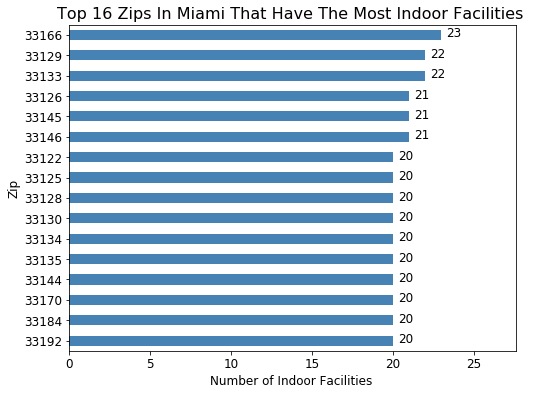

In [51]:
plot_category_group_total_bar(venues_total_top_reverse, 
                              'Zip',
                              'Total',
                              'Indoor Facilities', 
                              '',
                              total_max,
                              top_with_ties)

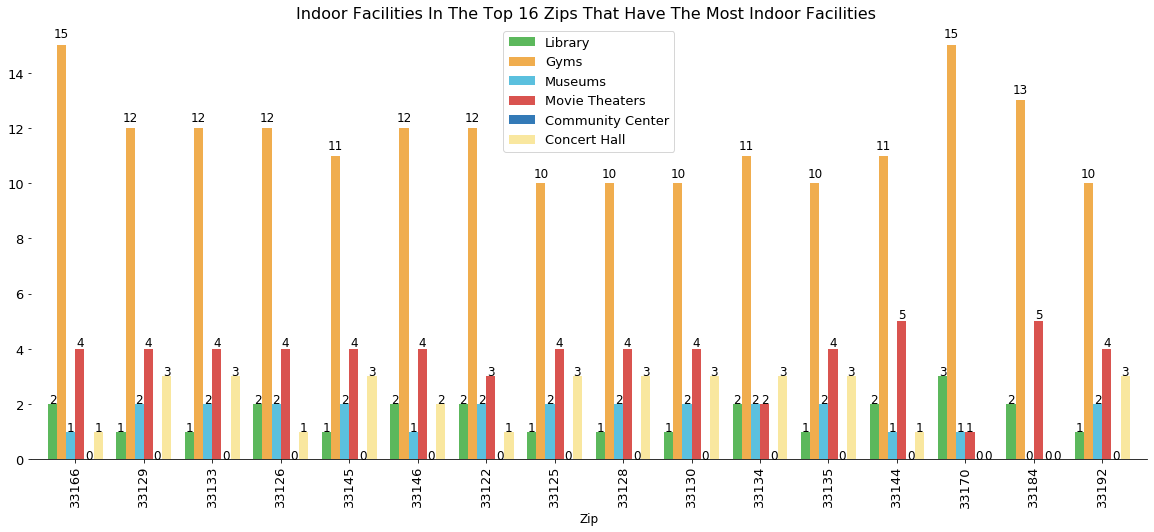

In [52]:
plot_category_group_bar(venues_total_top.set_index('Zip'), indoor_list, 'Indoor Facilities', '', top_with_ties)

##### (2) Which zips have the most libraries, gyms, museums, movie theaters, community centers and concert halls per 1000 people?

In [53]:
# sort by the number of Indoor Facilties per 1000 people in each zip
venues_average_top, venues_average_top_reverse, average_max, top_with_ties = sort_venues_by(
                        indoor_venues, 'Per 1000 people', 'Zip', 10, False, 'Indoor Facilities', ' per 1000 people')
venues_average_top

There are 10 zips with the most numbers of venues in the Indoor Facilities per 1000 people category.


,Zip,Population,Library,Gyms,Museums,Movie Theaters,Community Center,Concert Hall,Total,Per 1000 people
0,33192,550,1,10,2,4,0,3,20,36.36
1,33122,1146,2,12,2,3,0,1,20,17.45
2,33128,5110,1,10,2,4,0,3,20,3.91
3,33158,6430,3,11,1,4,0,0,19,2.95
4,33132,7770,0,11,2,3,0,3,19,2.45
5,33194,5430,3,9,0,0,1,0,13,2.39
6,33146,10010,2,12,1,4,0,2,21,2.10
7,33129,11920,1,12,2,4,0,3,22,1.85
8,33136,10850,1,10,2,3,0,3,19,1.75
9,33170,12430,3,15,1,1,0,0,20,1.61


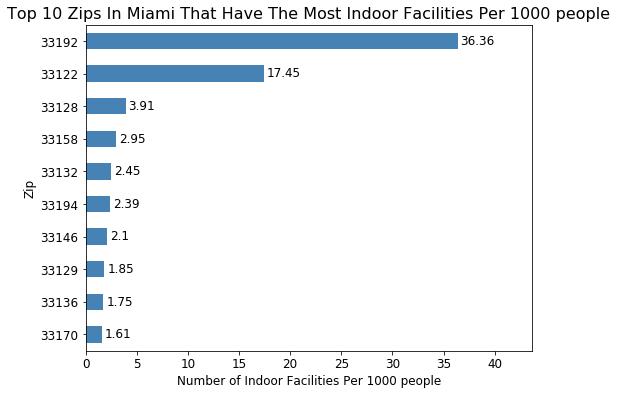

In [54]:
plot_category_group_total_bar(venues_average_top_reverse, 
                              'Zip',
                              'Per 1000 people',
                              'Indoor Facilities', 
                              'Per 1000 people',
                              average_max,
                              top_with_ties)

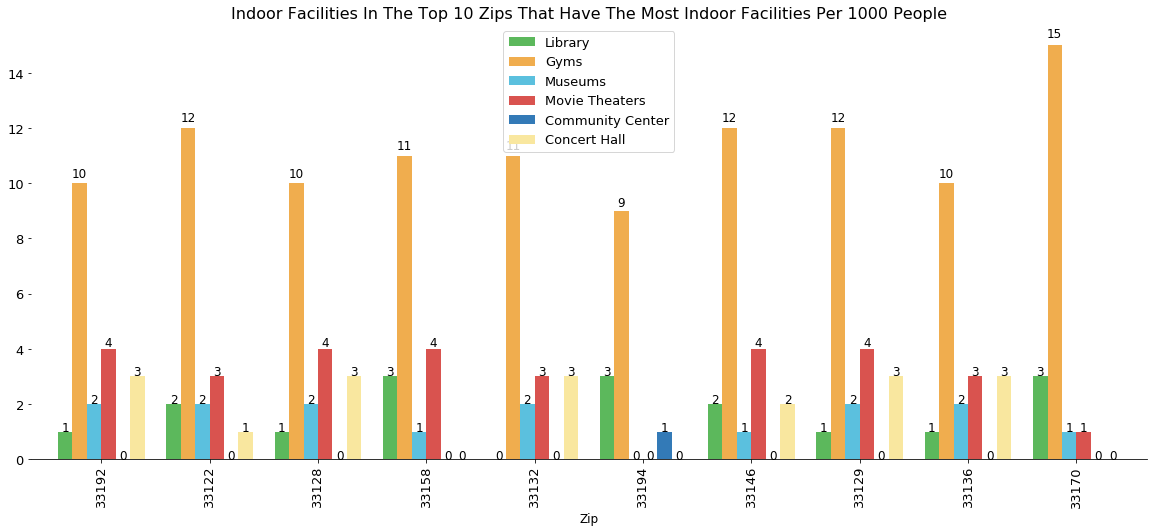

In [55]:
plot_category_group_bar(venues_average_top.set_index('Zip'), indoor_list, 'Indoor Facilities', 'Per 1000 People', top_with_ties)

#### 4) Outdoor Facilities (parks, trails, gardens, beaches, and lakes)

Get the outdoor facilities venue dataframe for all zips.

In [56]:
# Combine 'Park','Trail', 'Beach', 'Garden', 'Lake' to be 'Outdoor Facilities'
outdoor_list = ['Park','Trail', 'Beach', 'Garden', 'Lake']

In [57]:
outdoor_venues = create_comparing_group(selected_venues, outdoor_list)
outdoor_venues.head()

,Zip,Population,Park,Trail,Beach,Garden,Lake,Total,Per 1000 people
0,33122,1146,21,2,1,1,0,25,21.82
1,33125,43170,26,3,10,1,0,40,0.93
2,33126,42520,22,2,1,1,0,26,0.61
3,33127,24030,21,3,20,1,0,45,1.87
4,33128,5110,24,4,22,1,0,51,9.98


##### (1) Which zips have the most parks, trails, gardens, beaches and lakes?

In [58]:
# sort by total number of Outdoor Facilties in each zip
venues_total_top, venues_total_top_reverse, total_max, top_with_ties = sort_venues_by(
                    outdoor_venues, 'Total', 'Zip', 10, False, 'Outdoor Facilities', '')
venues_total_top

There are 11 zips with the most numbers of venues in the Outdoor Facilities category.


,Zip,Population,Park,Trail,Beach,Garden,Lake,Total,Per 1000 people
0,33138,23880,18,3,33,1,0,55,2.30
1,33131,15540,24,4,25,1,0,54,3.47
2,33132,7770,23,4,26,1,0,54,6.95
3,33137,16490,18,4,30,1,0,53,3.21
4,33128,5110,24,4,22,1,0,51,9.98
5,33136,10850,23,4,23,1,0,51,4.70
6,33181,15500,12,2,35,1,0,50,3.23
7,33129,11920,25,3,20,1,0,49,4.11
8,33130,21170,24,4,20,1,0,49,2.31
9,33150,24530,18,3,27,1,0,49,2.00


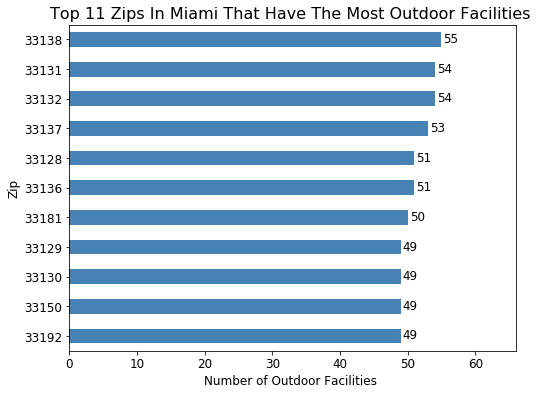

In [59]:
plot_category_group_total_bar(venues_total_top_reverse, 
                              'Zip',
                              'Total',
                              'Outdoor Facilities', 
                              '',
                              total_max,
                              top_with_ties)

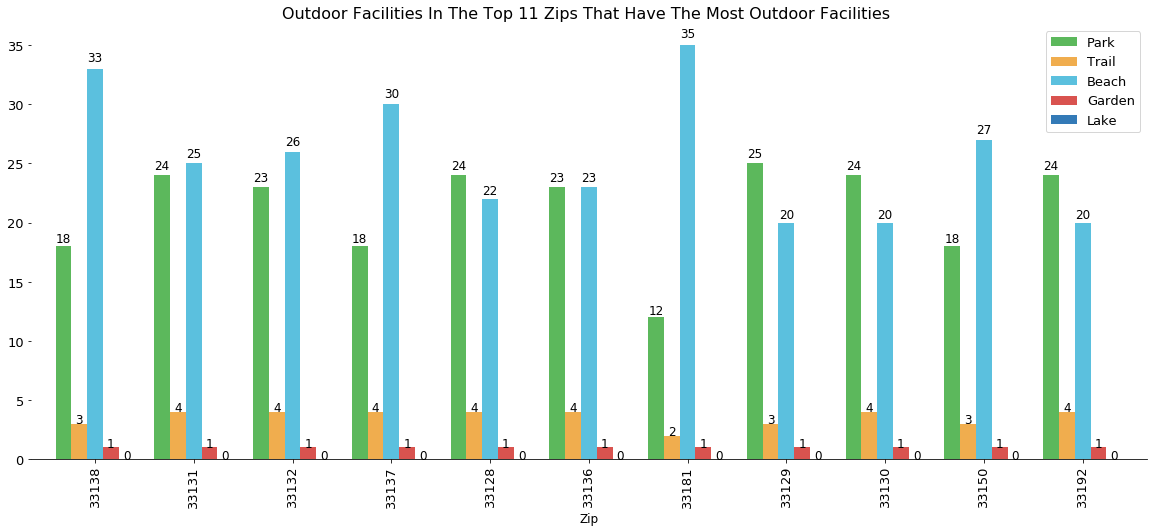

In [60]:
plot_category_group_bar(venues_total_top.set_index('Zip'), outdoor_list, 'Outdoor Facilities', '', top_with_ties)

##### (2) Which zips have the most parks, trails, gardens, beaches and lakes per 1000 people.

In [61]:
# sort by the number of Outdoor Facilties per 1000 people in each zip
venues_average_top, venues_average_top_reverse, average_max, top_with_ties = sort_venues_by(
                        outdoor_venues, 'Per 1000 people', 'Zip', 10, False, 'Outdoor Facilities', ' per 1000 people')
venues_average_top

There are 10 zips with the most numbers of venues in the Outdoor Facilities per 1000 people category.


,Zip,Population,Park,Trail,Beach,Garden,Lake,Total,Per 1000 people
0,33192,550,24,4,20,1,0,49,89.09
1,33122,1146,21,2,1,1,0,25,21.82
2,33128,5110,24,4,22,1,0,51,9.98
3,33132,7770,23,4,26,1,0,54,6.95
4,33136,10850,23,4,23,1,0,51,4.70
5,33129,11920,25,3,20,1,0,49,4.11
6,33194,5430,15,1,0,0,4,20,3.68
7,33131,15540,24,4,25,1,0,54,3.47
8,33181,15500,12,2,35,1,0,50,3.23
9,33137,16490,18,4,30,1,0,53,3.21


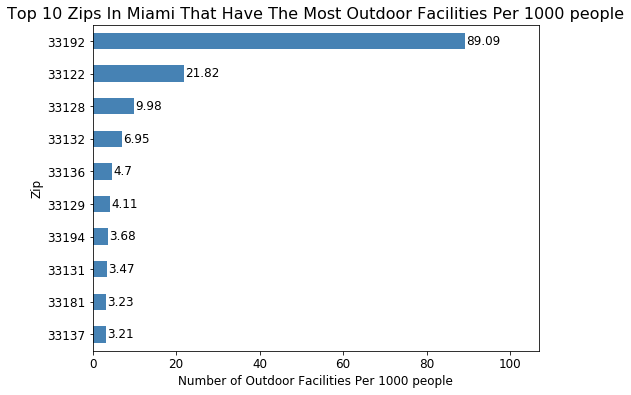

In [62]:
plot_category_group_total_bar(venues_average_top_reverse, 
                              'Zip',
                              'Per 1000 people',
                              'Outdoor Facilities', 
                              'Per 1000 people',
                              average_max,
                              top_with_ties)

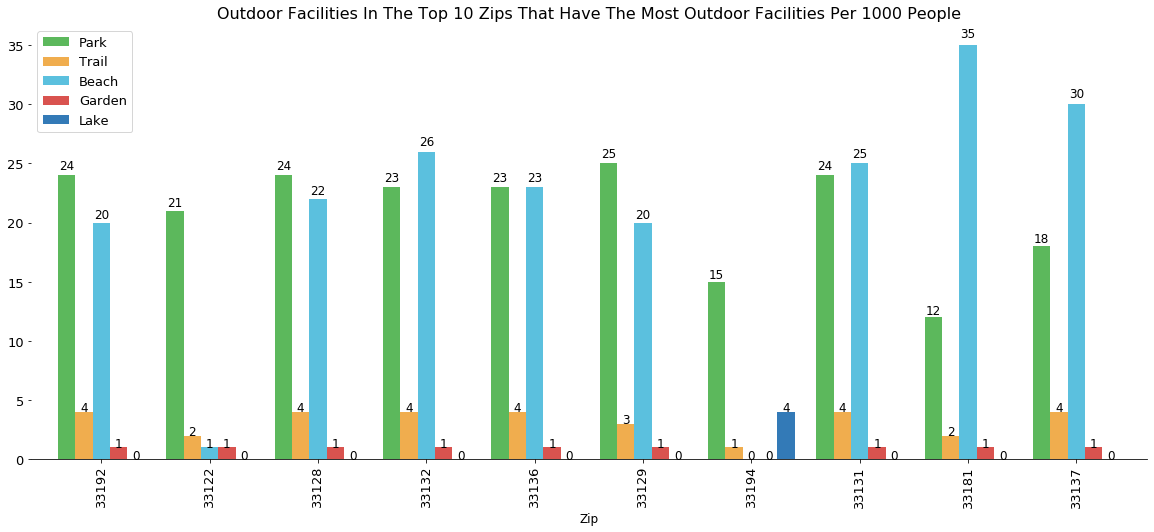

In [63]:
plot_category_group_bar(venues_average_top.set_index('Zip'), outdoor_list, 'Outdoor Facilities', 'Per 1000 People', top_with_ties)

## 4. Cluster the zips and examine the clusters <a id='section4'></a>

### Group rows by zips and by taking the mean of the frequency of occurrence of each category.

In [64]:
selected_grouped = onehot_selected.groupby('Zip').mean().reset_index()
selected_grouped

,Zip,Hospital,Medical Center,Urgent Care Center,Emergency Room,Hospital Ward,Grocery Store,Farmers Market,Supermarket,Library,...,Museums,Movie Theaters,Community Center,Concert Hall,Park,Trail,Lake,Garden,Beach,Nature Preserve
0,33122,0.000,0.0000,0.0000,0.000,0.0000,0.44,0.0000,0.02,0.0200,...,0.02,0.03,0.0000,0.01,0.2100,0.0200,0.00,0.01,0.01,0.00
1,33125,0.020,0.0000,0.0000,0.000,0.0000,0.30,0.0000,0.02,0.0100,...,0.02,0.04,0.0000,0.03,0.2600,0.0300,0.00,0.01,0.10,0.00
2,33126,0.020,0.0000,0.0000,0.000,0.0000,0.40,0.0000,0.02,0.0200,...,0.02,0.04,0.0000,0.01,0.2200,0.0200,0.00,0.01,0.01,0.00
3,33127,0.000,0.0000,0.0000,0.000,0.0000,0.27,0.0000,0.02,0.0100,...,0.02,0.03,0.0000,0.03,0.2100,0.0300,0.00,0.01,0.20,0.00
4,33128,0.010,0.0000,0.0000,0.000,0.0000,0.20,0.0000,0.01,0.0100,...,0.02,0.04,0.0000,0.03,0.2400,0.0400,0.00,0.01,0.22,0.00
5,33129,0.000,0.0000,0.0000,0.000,0.0000,0.20,0.0000,0.01,0.0100,...,0.02,0.04,0.0000,0.03,0.2500,0.0300,0.00,0.01,0.20,0.00
6,33130,0.010,0.0000,0.0000,0.000,0.0000,0.21,0.0000,0.01,0.0100,...,0.02,0.04,0.0000,0.03,0.2400,0.0400,0.00,0.01,0.20,0.00
7,33131,0.000,0.0000,0.0000,0.000,0.0000,0.19,0.0000,0.01,0.0000,...,0.02,0.03,0.0000,0.03,0.2400,0.0400,0.00,0.01,0.25,0.00
8,33132,0.010,0.0000,0.0000,0.000,0.0000,0.18,0.0000,0.01,0.0000,...,0.02,0.03,0.0000,0.03,0.2300,0.0400,0.00,0.01,0.26,0.00
9,33133,0.010,0.0000,0.0000,0.000,0.0000,0.31,0.0100,0.01,0.0100,...,0.02,0.04,0.0000,0.03,0.2600,0.0200,0.00,0.01,0.08,0.00


### Find the 10 most common venues for each zip code.

In [66]:
# A function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
column_names = ['Zip']
for i in np.arange(num_top_venues):
    try:
        column_names.append('{}{} Most Common Venue'.format(i+1, indicators[i]))
    except:
        column_names.append('{}th Most Common Venue'.format(i+1))
        
# create a new dataframe
zips_venues_sorted = pd.DataFrame(columns=column_names)
zips_venues_sorted['Zip'] = selected_grouped['Zip']
        
for i in np.arange(selected_grouped.shape[0]):
    zips_venues_sorted.iloc[i, 1:] = return_most_common_venues(selected_grouped.iloc[i, :], num_top_venues)

zips_venues_sorted

,Zip,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,33122,Grocery Store,Park,Gyms,Movie Theaters,Trail,Museums,Library,Supermarket,Garden,Concert Hall
1,33125,Grocery Store,Park,Gyms,Beach,Movie Theaters,Trail,Concert Hall,Museums,Supermarket,Hospital
2,33126,Grocery Store,Park,Gyms,Movie Theaters,Supermarket,Library,Museums,Hospital,Trail,Concert Hall
3,33127,Grocery Store,Park,Beach,Gyms,Trail,Concert Hall,Movie Theaters,Museums,Supermarket,Garden
4,33128,Park,Beach,Grocery Store,Gyms,Trail,Movie Theaters,Concert Hall,Museums,Supermarket,Library
5,33129,Park,Beach,Grocery Store,Gyms,Movie Theaters,Trail,Concert Hall,Museums,Garden,Library
6,33130,Park,Grocery Store,Beach,Gyms,Trail,Movie Theaters,Concert Hall,Museums,Supermarket,Library
7,33131,Beach,Park,Grocery Store,Gyms,Trail,Concert Hall,Movie Theaters,Museums,Garden,Supermarket
8,33132,Beach,Park,Grocery Store,Gyms,Trail,Concert Hall,Movie Theaters,Museums,Supermarket,Hospital
9,33133,Grocery Store,Park,Gyms,Beach,Movie Theaters,Concert Hall,Trail,Museums,Library,Farmers Market


### Run kmeans to cluster zips for different category groups, and examine the clusters.

Before clustering by different categories,  we need to re-organize the dataframe based on different category groups.

In [67]:
selected_grouped_clustering = selected_grouped
selected_grouped_clustering.loc[:,'Hospital Facilities'] = selected_grouped.reindex(columns=hospital_list).sum(axis = 1)
selected_grouped_clustering.loc[:,'Grocery Facilities'] = selected_grouped_clustering.reindex(columns=grocery_list).sum(axis = 1)
selected_grouped_clustering.loc[:,'Indoor Facilities'] = selected_grouped_clustering.reindex(columns=indoor_list).sum(axis = 1)
selected_grouped_clustering.loc[:,'Outdoor Facilities'] = selected_grouped_clustering.reindex(columns=outdoor_list).sum(axis = 1)
selected_grouped_clustering.head()

,Zip,Hospital,Medical Center,Urgent Care Center,Emergency Room,Hospital Ward,Grocery Store,Farmers Market,Supermarket,Library,...,Park,Trail,Lake,Garden,Beach,Nature Preserve,Hospital Facilities,Grocery Facilities,Indoor Facilities,Outdoor Facilities
0,33122,0.00,0.0,0.0,0.0,0.0,0.44,0.0,0.02,0.02,...,0.21,0.02,0.0,0.01,0.01,0.0,0.00,0.46,0.20,0.25
1,33125,0.02,0.0,0.0,0.0,0.0,0.30,0.0,0.02,0.01,...,0.26,0.03,0.0,0.01,0.10,0.0,0.02,0.32,0.20,0.40
2,33126,0.02,0.0,0.0,0.0,0.0,0.40,0.0,0.02,0.02,...,0.22,0.02,0.0,0.01,0.01,0.0,0.02,0.42,0.21,0.26
3,33127,0.00,0.0,0.0,0.0,0.0,0.27,0.0,0.02,0.01,...,0.21,0.03,0.0,0.01,0.20,0.0,0.00,0.29,0.18,0.45
4,33128,0.01,0.0,0.0,0.0,0.0,0.20,0.0,0.01,0.01,...,0.24,0.04,0.0,0.01,0.22,0.0,0.01,0.21,0.20,0.51


In [68]:
selected_grouped_clustering = selected_grouped_clustering[['Zip',
                                                               'Hospital Facilities', 
                                                               'Grocery Facilities', 
                                                               'Indoor Facilities', 
                                                               'Outdoor Facilities']]
selected_grouped_clustering.head()

,Zip,Hospital Facilities,Grocery Facilities,Indoor Facilities,Outdoor Facilities
0,33122,0.00,0.46,0.20,0.25
1,33125,0.02,0.32,0.20,0.40
2,33126,0.02,0.42,0.21,0.26
3,33127,0.00,0.29,0.18,0.45
4,33128,0.01,0.21,0.20,0.51


#### Cluster and examine the clusters for each category groups.

Define a function to get 1) a clustering dataframe for a category group; 2) a dataframe showing the means, min, max, number of zips of each cluster.

In [69]:
def get_cluster_df(df, category, k):
    facilities = df[['Zip', category]]
    
    kclusters = k

    facilities_clustering = facilities.drop('Zip', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(facilities_clustering)

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10] 
    
    merged = facilities.copy()

    # add clustering labels
    merged["Cluster Labels"] = kmeans.labels_
    
    merged = pd.merge(merged,miami_data[['latitude','longitude']],on=merged['Zip'], how='left')
    del merged['key_0']
    
    # sort by Cluster Labels in ascending order, then by mean in descending order, and then by Zip in ascending order
    merged = merged.iloc[np.lexsort((merged['Zip'], -merged[category], merged['Cluster Labels']))].reset_index(drop=True)
    
    result = merged.groupby('Cluster Labels').agg({category: ['mean', 'min', 'max', 'count']})
    
    return [merged, result]

Define a function to create a clustering map.

In [70]:
def create_clustering_map(merged_df, k):
    kclusters = k
    
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(merged_df['latitude'], merged_df['longitude'], merged_df['Zip'], merged_df['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)
       
    return map_clusters

Choose the k value.

In [71]:
k = 3

##### 1) Clustering by Hospital Facilities (hospitals, medical centers, urgent care centers, emergency rooms, and hospital wards)

In [72]:
hospital_clustering, hospital_clustering_stat = get_cluster_df(selected_grouped_clustering, 'Hospital Facilities', k)
hospital_clustering

,Zip,Hospital Facilities,Cluster Labels,latitude,longitude
0,33125,0.0200,0,25.78,-80.24
1,33126,0.0200,0,25.78,-80.30
2,33135,0.0200,0,25.77,-80.24
3,33166,0.0200,0,25.82,-80.30
4,33128,0.0100,0,25.78,-80.20
5,33130,0.0100,0,25.77,-80.20
6,33132,0.0100,0,25.78,-80.18
7,33133,0.0100,0,25.73,-80.24
8,33136,0.0100,0,25.79,-80.20
9,33137,0.0100,0,25.82,-80.17


In [73]:
create_clustering_map(hospital_clustering, k)

In [74]:
hospital_clustering_stat

Hospital Facilities                      
                              mean     min     max count
Cluster Labels                                          
0                         0.006552  0.0000  0.0200    29
1                         0.212500  0.2125  0.2125     1
2                         0.052308  0.0300  0.0800    26

##### Hospital facilities cluster 0, 29 zips (red dots), means < 0.02. These are areas that have fewer hosptial facilities.

In [75]:
hospital_clustering.loc[hospital_clustering['Cluster Labels'] == 0]

,Zip,Hospital Facilities,Cluster Labels,latitude,longitude
0,33125,0.02,0,25.78,-80.24
1,33126,0.02,0,25.78,-80.30
2,33135,0.02,0,25.77,-80.24
3,33166,0.02,0,25.82,-80.30
4,33128,0.01,0,25.78,-80.20
5,33130,0.01,0,25.77,-80.20
6,33132,0.01,0,25.78,-80.18
7,33133,0.01,0,25.73,-80.24
8,33136,0.01,0,25.79,-80.20
9,33137,0.01,0,25.82,-80.17


##### Hospital facilities cluster 1, 1 zip (purple dot), means = 0.2125. This is the area that has relatively more hosptial facilities.

In [76]:
hospital_clustering.loc[hospital_clustering['Cluster Labels'] == 1]

,Zip,Hospital Facilities,Cluster Labels,latitude,longitude
29,33194,0.2125,1,25.71,-80.58


##### Hospital facilities cluster 2, 26 zips (green dots), means between 0.03-0.08. These are areas that have medium numbers of hosptial facilities. 

In [77]:
hospital_clustering.loc[hospital_clustering['Cluster Labels'] == 2]

,Zip,Hospital Facilities,Cluster Labels,latitude,longitude
30,33189,0.08,2,25.57,-80.34
31,33190,0.08,2,25.56,-80.35
32,33196,0.07,2,25.65,-80.49
33,33157,0.07,2,25.61,-80.34
34,33158,0.06,2,25.64,-80.31
35,33175,0.06,2,25.73,-80.41
36,33177,0.06,2,25.60,-80.40
37,33187,0.06,2,25.60,-80.51
38,33155,0.05,2,25.74,-80.31
39,33165,0.05,2,25.73,-80.36


##### 2) Clustering by Grocery Facilities (grocery stores, farmers markets and supermarkets)

In [78]:
grocery_clustering, grocery_clustering_stat = get_cluster_df(selected_grouped_clustering, 'Grocery Facilities', k)
grocery_clustering

,Zip,Grocery Facilities,Cluster Labels,latitude,longitude
0,33172,0.5700,0,25.79,-80.36
1,33186,0.5600,0,25.65,-80.41
2,33176,0.5500,0,25.66,-80.36
3,33183,0.5500,0,25.70,-80.40
4,33173,0.5400,0,25.70,-80.36
5,33174,0.5400,0,25.76,-80.36
6,33165,0.5300,0,25.73,-80.36
7,33182,0.5300,0,25.78,-80.41
8,33175,0.5200,0,25.73,-80.41
9,33178,0.5200,0,25.85,-80.41


In [79]:
create_clustering_map(grocery_clustering, k)

In [80]:
grocery_clustering_stat 

Grocery Facilities                    
                             mean   min     max count
Cluster Labels                                       
0                        0.503214  0.44  0.5700    28
1                        0.350556  0.29  0.4200    18
2                        0.218250  0.19  0.2625    10

##### Grocery facilities cluster 0, 28 zips (red dots), means between 0.44-0.57. These are areas that have relatively more grocery facilities. 

In [81]:
grocery_clustering.loc[grocery_clustering['Cluster Labels'] == 0]

,Zip,Grocery Facilities,Cluster Labels,latitude,longitude
0,33172,0.57,0,25.79,-80.36
1,33186,0.56,0,25.65,-80.41
2,33176,0.55,0,25.66,-80.36
3,33183,0.55,0,25.70,-80.40
4,33173,0.54,0,25.70,-80.36
5,33174,0.54,0,25.76,-80.36
6,33165,0.53,0,25.73,-80.36
7,33182,0.53,0,25.78,-80.41
8,33175,0.52,0,25.73,-80.41
9,33178,0.52,0,25.85,-80.41


##### Grocery facilities cluster 1, 18 zips (purple dots), means between 0.29-0.42. These are areas that have medium numbers of grocery facilities. 

In [82]:
grocery_clustering.loc[grocery_clustering['Cluster Labels'] == 1]

,Zip,Grocery Facilities,Cluster Labels,latitude,longitude
28,33126,0.42,1,25.78,-80.30
29,33189,0.42,1,25.57,-80.34
30,33147,0.41,1,25.85,-80.24
31,33162,0.40,1,25.93,-80.18
32,33146,0.39,1,25.72,-80.27
33,33179,0.39,1,25.96,-80.18
34,33134,0.37,1,25.75,-80.27
35,33168,0.35,1,25.89,-80.21
36,33180,0.34,1,25.96,-80.14
37,33142,0.34,1,25.81,-80.24


##### Grocery facilities cluster 2, 10 zips (green dots), means between 0.19-0.2625. These are areas that have relatively fewer grocery facilities. 

In [83]:
grocery_clustering.loc[grocery_clustering['Cluster Labels'] == 2]

,Zip,Grocery Facilities,Cluster Labels,latitude,longitude
46,33194,0.2625,2,25.71,-80.58
47,33138,0.2400,2,25.85,-80.18
48,33130,0.2200,2,25.77,-80.20
49,33136,0.2200,2,25.79,-80.20
50,33192,0.2200,2,25.77,-80.20
51,33128,0.2100,2,25.78,-80.20
52,33129,0.2100,2,25.75,-80.19
53,33137,0.2100,2,25.82,-80.17
54,33131,0.2000,2,25.77,-80.18
55,33132,0.1900,2,25.78,-80.18


##### 3) Clustering by Indoor Facilities (libraries, gyms, museums, movie theaters, community centers and concert halls)

In [84]:
indoor_clustering, indoor_clustering_stat = get_cluster_df(selected_grouped_clustering, 'Indoor Facilities', k)
indoor_clustering

,Zip,Indoor Facilities,Cluster Labels,latitude,longitude
0,33168,0.1200,0,25.89,-80.21
1,33138,0.1100,0,25.85,-80.18
2,33169,0.1100,0,25.94,-80.21
3,33167,0.1100,0,25.88,-80.24
4,33179,0.1100,0,25.96,-80.18
5,33161,0.1000,0,25.89,-80.18
6,33181,0.0800,0,25.90,-80.15
7,33162,0.0800,0,25.93,-80.18
8,33131,0.1800,1,25.77,-80.18
9,33143,0.1800,1,25.70,-80.30


In [85]:
create_clustering_map(indoor_clustering, k)

In [86]:
indoor_clustering_stat 

Indoor Facilities                  
                            mean   min   max count
Cluster Labels                                    
0                       0.102500  0.08  0.12     8
1                       0.165700  0.14  0.18    25
2                       0.201304  0.19  0.23    23

##### Indoor facilities cluster 0, 8 zips (red dots), means between 0.08-0.12. These are areas that have relatively fewer indoor facilities. 

In [87]:
indoor_clustering.loc[indoor_clustering['Cluster Labels'] == 0]

,Zip,Indoor Facilities,Cluster Labels,latitude,longitude
0,33168,0.12,0,25.89,-80.21
1,33138,0.11,0,25.85,-80.18
2,33169,0.11,0,25.94,-80.21
3,33167,0.11,0,25.88,-80.24
4,33179,0.11,0,25.96,-80.18
5,33161,0.10,0,25.89,-80.18
6,33181,0.08,0,25.90,-80.15
7,33162,0.08,0,25.93,-80.18


##### Indoor facilities cluster 1, 25 zips (purple dots), means between 0.14-0.18. These are areas that have medium numbers of indoor facilities. 

In [88]:
indoor_clustering.loc[indoor_clustering['Cluster Labels'] == 1]

,Zip,Indoor Facilities,Cluster Labels,latitude,longitude
8,33131,0.1800,1,25.77,-80.18
9,33143,0.1800,1,25.70,-80.30
10,33156,0.1800,1,25.67,-80.30
11,33127,0.1800,1,25.81,-80.21
12,33175,0.1800,1,25.73,-80.41
13,33178,0.1800,1,25.85,-80.41
14,33189,0.1800,1,25.57,-80.34
15,33193,0.1800,1,25.70,-80.47
16,33142,0.1700,1,25.81,-80.24
17,33172,0.1700,1,25.79,-80.36


##### Indoor facilities cluster 2, 23 zips (green dots), means between 0.19-0.23. These are areas that have relatively more indoor facilities. 

In [89]:
indoor_clustering.loc[indoor_clustering['Cluster Labels'] == 2]

,Zip,Indoor Facilities,Cluster Labels,latitude,longitude
33,33166,0.23,2,25.82,-80.30
34,33129,0.22,2,25.75,-80.19
35,33133,0.22,2,25.73,-80.24
36,33126,0.21,2,25.78,-80.30
37,33145,0.21,2,25.75,-80.23
38,33146,0.21,2,25.72,-80.27
39,33125,0.20,2,25.78,-80.24
40,33128,0.20,2,25.78,-80.20
41,33130,0.20,2,25.77,-80.20
42,33135,0.20,2,25.77,-80.24


##### 4) Clustering by Outdoor Facilities (parks, trails, gardens, beaches and lakes)

In [90]:
outdoor_clustering, outdoor_clustering_stat = get_cluster_df(selected_grouped_clustering, 'Outdoor Facilities', k)
outdoor_clustering

,Zip,Outdoor Facilities,Cluster Labels,latitude,longitude
0,33138,0.55,0,25.85,-80.18
1,33131,0.54,0,25.77,-80.18
2,33132,0.54,0,25.78,-80.18
3,33137,0.53,0,25.82,-80.17
4,33128,0.51,0,25.78,-80.20
5,33136,0.51,0,25.79,-80.20
6,33181,0.50,0,25.90,-80.15
7,33129,0.49,0,25.75,-80.19
8,33130,0.49,0,25.77,-80.20
9,33150,0.49,0,25.85,-80.21


In [91]:
create_clustering_map(outdoor_clustering, k)

In [92]:
outdoor_clustering_stat 

Outdoor Facilities                  
                             mean   min   max count
Cluster Labels                                     
0                        0.503846  0.45  0.55    13
1                        0.205333  0.15  0.28    30
2                        0.377692  0.31  0.42    13

##### Outdoor facilities cluster 0, 13 zips (red dots), means between 0.45-0.55. These are areas that have relatively more outdoor facilities. 

In [93]:
outdoor_clustering.loc[outdoor_clustering['Cluster Labels'] == 0]

,Zip,Outdoor Facilities,Cluster Labels,latitude,longitude
0,33138,0.55,0,25.85,-80.18
1,33131,0.54,0,25.77,-80.18
2,33132,0.54,0,25.78,-80.18
3,33137,0.53,0,25.82,-80.17
4,33128,0.51,0,25.78,-80.20
5,33136,0.51,0,25.79,-80.20
6,33181,0.50,0,25.90,-80.15
7,33129,0.49,0,25.75,-80.19
8,33130,0.49,0,25.77,-80.20
9,33150,0.49,0,25.85,-80.21


##### Outdoor facilities cluster 1, 30 zips (purple dots), means between 0.15-0.28. These are areas that have relatively fewer outdoor facilities. 

In [94]:
outdoor_clustering.loc[outdoor_clustering['Cluster Labels'] == 1]

,Zip,Outdoor Facilities,Cluster Labels,latitude,longitude
13,33146,0.28,1,25.72,-80.27
14,33126,0.26,1,25.78,-80.30
15,33122,0.25,1,25.79,-80.30
16,33143,0.25,1,25.70,-80.30
17,33189,0.25,1,25.57,-80.34
18,33194,0.25,1,25.71,-80.58
19,33190,0.23,1,25.56,-80.35
20,33144,0.23,1,25.76,-80.31
21,33156,0.23,1,25.67,-80.30
22,33166,0.23,1,25.82,-80.30


##### Outdoor facilities cluster 2, 13 zips (green dots), means between 0.31-0.42. These are areas that have medium numbers of outdoor facilities. 

In [95]:
outdoor_clustering.loc[outdoor_clustering['Cluster Labels'] == 2]

,Zip,Outdoor Facilities,Cluster Labels,latitude,longitude
43,33142,0.42,2,25.81,-80.24
44,33135,0.41,2,25.77,-80.24
45,33145,0.41,2,25.75,-80.23
46,33168,0.41,2,25.89,-80.21
47,33125,0.40,2,25.78,-80.24
48,33180,0.39,2,25.96,-80.14
49,33147,0.38,2,25.85,-80.24
50,33162,0.38,2,25.93,-80.18
51,33133,0.37,2,25.73,-80.24
52,33179,0.37,2,25.96,-80.18


## Result <a id='section5'></a>

#### 1. Let's find those zips in most of the clusters with relatively more facilities.

Get all the zips with relatively more hospital facilites. (Note: as there are only 1 zip in the more hospital cluster, we include those zips with moderate numbers of hospital facilites here.)

In [96]:
hospital_df = hospital_clustering.loc[hospital_clustering['Cluster Labels'].isin([1,2])][['Zip']].reset_index(drop=True)
hospital_df['Hospital Facilities'] = 1

Get all the zips with relatively more grocery facilities.

In [97]:
grocery_df = grocery_clustering.loc[grocery_clustering['Cluster Labels'] == 0][['Zip']].reset_index(drop=True)
grocery_df['Grocery Facilities'] = 1

Get all the zips with relatively more indoor facilities.

In [98]:
indoor_df = indoor_clustering.loc[indoor_clustering['Cluster Labels'] == 2][['Zip']].reset_index(drop=True)
indoor_df['Indoor Facilities'] = 1

Get all the zips with relatively more outdoor facilities.

In [99]:
outdoor_df = outdoor_clustering.loc[outdoor_clustering['Cluster Labels'] == 0][['Zip']].reset_index(drop=True)
outdoor_df['Outdoor Facilities'] = 1

Create a dataframe to show the zips with more of the 4 category groups that customers are interested in.

In [100]:
df_tmp = pd.concat([hospital_df,grocery_df,indoor_df,outdoor_df]).fillna(0)
df_tmp = df_tmp.groupby('Zip').sum()
df_tmp.loc[:,'Total'] = df_tmp.loc[:,['Hospital Facilities', 'Grocery Facilities', 'Indoor Facilities', 'Outdoor Facilities']].sum(axis=1)
df_tmp = df_tmp.astype(int)
df_tmp.reset_index(inplace=True)
zips = df_tmp.sort_values(['Total', 'Zip'], ascending=[False, True]).reset_index(drop=True)
zips

,Zip,Hospital Facilities,Grocery Facilities,Indoor Facilities,Outdoor Facilities,Total
0,33144,1,1,1,0,3
1,33155,1,1,1,0,3
2,33158,1,1,1,0,3
3,33170,1,1,1,0,3
4,33182,1,1,1,0,3
5,33184,1,1,1,0,3
6,33185,1,1,1,0,3
7,33187,1,1,1,0,3
8,33122,0,1,1,0,2
9,33128,0,0,1,1,2


In [101]:
tmp = zips.rename(columns={'Zip':'zip'})
final_zips = tmp.merge(miami_data, on='zip', how='left')
max_value = final_zips['Total'].max()
final_zips = final_zips[final_zips['Total'] == max_value]
final_zips

,zip,Hospital Facilities,Grocery Facilities,Indoor Facilities,Outdoor Facilities,Total,primary_city,county,latitude,longitude,irs_estimated_population_2015
0,33144,1,1,1,0,3,Miami,Miami-Dade County,25.76,-80.31,23450
1,33155,1,1,1,0,3,Miami,Miami-Dade County,25.74,-80.31,41220
2,33158,1,1,1,0,3,Miami,Miami-Dade County,25.64,-80.31,6430
3,33170,1,1,1,0,3,Miami,Miami-Dade County,25.56,-80.46,12430
4,33182,1,1,1,0,3,Miami,Miami-Dade County,25.78,-80.41,13380
5,33184,1,1,1,0,3,Miami,Miami-Dade County,25.76,-80.41,19510
6,33185,1,1,1,0,3,Miami,Miami-Dade County,25.73,-80.45,26580
7,33187,1,1,1,0,3,Miami,Miami-Dade County,25.60,-80.51,17200


#### 2. Create a map showing those zips with most category groups of interest.

In [102]:
map_miami = folium.Map(location=[latitude, longitude], zoom_start=10)
# add markers to map
for lat, lng, label in zip(final_zips['latitude'], final_zips['longitude'], final_zips['zip']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_miami)  
map_miami

As customers are more interested in four category groups related to their retirement lifes (hospital facilities, grocery shopping facilities, indoor entertainment facilities, outdoor facilities), our analysis did clustering on each of these groups. For each group, I clustered those 56 standard zips in Miami into 3 clusters, representing zips with relatively more facilities, relatively fewer facilities, and median number of facilities. 
<br/><br/>
Then I would like to show customers the zips that occur most frequently in the clusters with "relatively more facilities". Please note there is only 1 zip in the "relatively more facilities" cluster for hospital facilities, so I included the cluster with "median number of facilities" for this category group as well. As shown in the dataframe final_zips, there are 8 zips appearing in 3 out of all 4 clusters with relatively more facilities (or median number for hospital facilities). It seems that all of these 8 zips are with high concentration of hospital facilities, grocery facilities, and indoor facilities.
<br/><br/>
The map marking all these 8 final top zips, as shown above, tells the customers the distribution of the areas.

## Discussion <a id='section6'></a>

In this project, our major category groups are hospital facilities, grocery facilities, indoor facilities and outdoor facilities. But different customers may have different preferences. With slight changes of the category ids to call the Foursquare API, this project is reusable for other categories, such as restaurants, residences, gas stations, etc. It can also be reused for other cities or counties or areas in the country.

## Conclusion <a id='section7'></a>

Our analysis could help people who would relocate to Miami for retirement to answer the following questions:
<br/><br/>
    &nbsp;&nbsp;&nbsp;&nbsp;Which zips have the most hospitals, medical centers, urgent care centers, emergency rooms and hospital wards?\
    &nbsp;&nbsp;&nbsp;&nbsp;Which zips have the most grocery stores, farmers markets, and supermarkets?\
    &nbsp;&nbsp;&nbsp;&nbsp;Which zips have the most libraries, gyms, museums, movie theaters, community centers, and concert halls?\
    &nbsp;&nbsp;&nbsp;&nbsp;Which zips have the most parks, trails, gardens, beaches, and lakes?\
    &nbsp;&nbsp;&nbsp;&nbsp;Which zips have the highest average facilities per 1000 people for those category groups?\
    &nbsp;&nbsp;&nbsp;&nbsp;What are the 10 most common venues for each zip code?\
    &nbsp;&nbsp;&nbsp;&nbsp;If we cluster the zips into 3 clusters for each category group, how is the distribution of all the zips?\
    &nbsp;&nbsp;&nbsp;&nbsp;Which zips will be in the final list of consideration because they occur most frequently in the clusters with "relatively more facilities"?\
    &nbsp;&nbsp;&nbsp;&nbsp;And where are they located on the city map?
<br/><br/>
I used Foursquare API to get the venues for all the standard zips in Miami. I plotted bar charts to demonstrate the total and the average number of facilities for each category group for the top zips. Bar charts are also used to compare each venue in the category group for the top zips. With kmeans clustering method, I clustered the zips into 3 clusters based on the concentration of each category group, and marked them with different colors on the Miami map. Finally, I found the zip list appearing in most clusters having more facilities.
    
The final decision on which zips of the city they would move to will be made by customers based on their individual or specific requirements/interets. With minor changes, this analysis can also be used by customers who would relocate to any city in the country with other preferences. Furthermore, I can extend this project to analyze and compare the neighborhoods within each zip on the final list.